In [458]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import hvplot.xarray
from glob import glob
from tqdm import tqdm
from xhistogram.xarray import histogram
import numpy as np
from matplotlib.colors import ListedColormap
import requests
import geopandas as gpd
from tools import process_satellite_image, format_lat_lon_ticks
from scipy.signal import detrend
import matplotlib.colors as mcolors
from cmcrameri import cm
import matplotlib.gridspec as gridspec
from tools import load_ana_data
import cmasher as cmr
from tools import lonlim, latlim

In [2]:
landsat = xr.open_dataset("../data/external/landsat/before_large.nc")
landsat = process_satellite_image(landsat, gamma=0.9)
gdf = gpd.read_file("../data/external/shapefiles/RS_Municipios_2022/RS_Municipios_2022.shp")
state = gpd.GeoDataFrame(gdf.unary_union, columns=["geometry"], crs="EPSG:4326")

In [3]:
url = "https://psl.noaa.gov/data/correlation/nina34.anom.data"
response = requests.get(url)
response.raise_for_status()  # Raise an error if the request fails
data = response.text

lines = data.split("\n")[1:-4]
data = pd.DataFrame([line.split() for line in lines])
data = data.astype(float)
data.set_index(0, inplace=True)
data.index.name="year"
enso = (
    data.reset_index()
    .melt(id_vars='year', var_name='month', value_name='enso')
    .set_index(["year", "month"]).to_xarray()
)
enso = enso.where(enso!=-99.99).enso

In [4]:
elnino = enso.year.where(enso.mean("month")>0.5, drop=True).values
lanina = enso.year.where(enso.mean("month")<-0.5, drop=True).values

In [5]:
def parse_station_data(filename):
    """Reads a file containing station data and returns a dictionary for the first station."""

    station_data = {}

    with open(filename, 'r') as file:
        for line in file:
            if line.strip():  # Ignore empty lines
                key, value = line.split(':')
                key = key.strip().lower()
                value = value.strip()

                if key == 'codigo estacao':
                    value = value
                elif key in ['latitude', 'longitude', 'altitude']:
                    value = float(value)
                elif key in ['data inicial', 'data final']:
                    value = datetime.strptime(value, '%Y-%m-%d')

                station_data[key] = value
            else:
                # Empty line found, stop reading
                break  

    return station_data

In [6]:
kw = {
    'skiprows': 11,
    'sep': ';',
    'usecols': range(0, 3),
    'names': ['date', 'hour', 'rain']
}


ds = []
fnames = glob("../data/external/inmet/*_/*.csv")
for fname in tqdm(fnames):
    df = pd.read_csv(fname, **kw)
    if df.size>10:
        info = parse_station_data(fname)
        df.index = [datetime.strptime(f"{date} {hour:04d}", "%Y-%m-%d %H%M") for date, hour in zip(df["date"], df["hour"])]
        df = df.drop(["date", "hour"], axis=1)
        df.index.name = "time"
        dsi = df.to_xarray()
        dsi = dsi.assign(
            longitude=info["longitude"],
            latitude=info["latitude"],
            name=info["nome"],
            id=info["codigo estacao"]
        )
        dsi = dsi.expand_dims("station").set_coords(["longitude","latitude","name","id"])
        ds.append(dsi)
ds = xr.concat(ds, "station")
ds = ds.isel(station=np.argwhere(~np.isnan(ds.rain).all("time").values).ravel())

100%|█████████████████████████████████████████| 105/105 [01:27<00:00,  1.20it/s]


In [44]:
enso_stacked = enso.stack(time=["year", "month"]).dropna("time")
time_stacked = enso_stacked.time.values
enso_stacked["time"] = [datetime(int(year), month, 28) for year, month in time_stacked]

/tmp/ipykernel_280044/3770533554.py:3: FutureWarning: updating coordinate 'time' with a PandasMultiIndex would leave the multi-index level coordinates ['year', 'month'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['time', 'year', 'month'])` before assigning new coordinate values.
  enso_stacked["time"] = [datetime(int(year), month, 28) for year, month in time_stacked]


In [373]:
dsm = ds.rain.resample(time="1m").sum()
dsm = dsm.where(dsm>0)
clim = dsm.median("station").groupby("time.month").median().interp(month=dsm.time.dt.month)
anomaly = (dsm-dsm.groupby("time.month").median().interp(month=dsm.time.dt.month))

frac = 0.3
rain_enso = (
    anomaly.groupby(((enso_stacked.interp(time=dsm.time, method="nearest")/frac).round()*frac))
    .apply(lambda group: group.groupby("time.month").median().median("station"))
).rolling(month=3, enso=5, center=True, min_periods=1).mean()

da = anomaly.stack(obs=["station", "time"])
rain_enso_std = (
    da.groupby(((enso_stacked.interp(time=da.time, method="nearest")/frac).round()*frac))
    .apply(lambda group: group.groupby("time.month").std())
).rolling(month=3, enso=5, center=True, min_periods=1).mean()

In [210]:
rsum = ds.rain.sel(time=slice("2024-04-26","2024-05-06")).sum("time")
rsum = rsum.where(rsum>0, drop=True)
rsum.isel(station=np.argsort(rsum)[::-1])

<xarray.DataArray 'rain' (station: 42)> Size: 336B
array([653.8, 610.2, 569.4, 512.4, 502. , 403.8, 402.6, 396.4, 395.8,
       392.8, 384.8, 378.8, 372. , 368.6, 361.6, 355. , 342. , 335.2,
       332.8, 306.2, 300.2, 295.2, 291.6, 289.2, 289. , 254.8, 248. ,
       229.2, 226.4, 224.2, 203.8, 184.4, 180.4, 171.2, 170.2, 162.2,
       158.6, 154.2, 146.2, 135.8,  63.6,  37.2])
Coordinates:
    longitude  (station) float64 336B -51.53 -52.54 -50.83 ... -56.02 -57.08
    latitude   (station) float64 336B -29.16 -28.86 -29.37 ... -28.65 -29.84
    name       (station) <U39 7kB 'BENTO GONCALVES' 'SOLEDADE' ... 'URUGUAIANA'
    id         (station) <U5 840B 'A840' 'A837' 'A879' ... 'A899' 'A830' 'A809'
Dimensions without coordinates: station

In [262]:
rsum.mean()

<xarray.DataArray 'rain' ()> Size: 8B
array(304.56666667)

In [10]:
daily = ds.resample(time="1d").sum(skipna=False).reset_coords(["longitude", "latitude"])
daily["name"] = ("station", ["PORTO ALEGRE" if "PORTO ALEGRE" in name else name for name in daily.name.values])
daily = daily.groupby("name").mean().set_coords(["longitude", "latitude"]).rain

In [11]:
keep = (
    ((~np.isnan(daily)).sel(time=slice(None, "1980-01-01")).sum("time")>0)&
    ((~np.isnan(daily)).sel(time=slice("2010-01-01", None)).sum("time")>0)
)

In [12]:
yearly = daily.groupby("time.year").sum()
yearly = yearly.where(yearly>0)
yearly = yearly.median("year")
yearly = yearly.where(yearly>900)

dsum = daily.sel(time=slice("2024-04-26","2024-05-06")).sum("time")
dsum = dsum.where(dsum>0).dropna("name")

(array([2., 2., 5., 8., 8., 8., 5., 1., 1., 1.]),
 array([ 2.98483511,  6.8196175 , 10.65439989, 14.48918228, 18.32396467,
        22.15874705, 25.99352944, 29.82831183, 33.66309422, 37.49787661,
        41.332659  ]),
 <BarContainer object of 10 artists>)

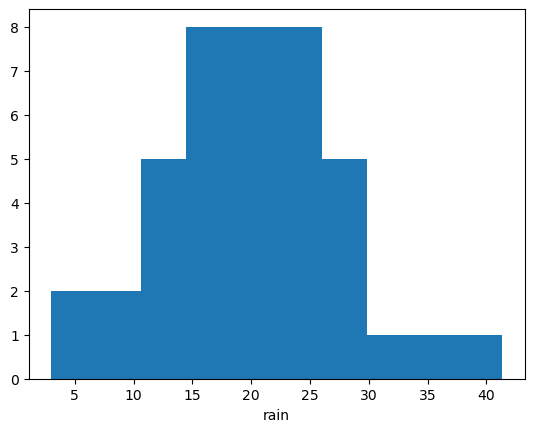

In [13]:
(100*dsum/yearly).plot.hist(bins=10)

In [204]:
threshold = 4
min_ndays = 3

events = []
for name in tqdm(daily["name"].values[keep]):
    station = daily.sel(name=name)
    counter = 1
    event_id = ((station>threshold)*1).values
    for i in range(1, len(event_id)):
        if event_id[i] == 1 and event_id[i - 1] == 0:
            counter += 1
        if event_id[i] == 1:
            event_id[i] = counter
    
    event_id = (xr.ones_like(station)*event_id)
    station_events = xr.merge([
        station.time.groupby(event_id).min(),
        station.groupby(event_id).count().rename("ndays"),
        station.groupby(event_id).sum().rename("total_rain"),
        station.groupby(event_id).max().rename("max_rain"),
    ]).rename(rain="event").isel(event=slice(1,None))
    
    station_events = station_events.where(station_events.ndays>min_ndays, drop=True)
    events.append(station_events)
events = xr.concat(events,"name")

# remove the event that only happened in the Rio Grande station in Feb 1990.
# We looked on old newspapers and couldn't find a reference about this event.
events = events.where(~((events.name=="RIO GRANDE")&(events.time.dt.year==1990)))

100%|███████████████████████████████████████████| 25/25 [00:01<00:00, 13.17it/s]


In [279]:
events.total_rain.quantile([0.1, 0.5, 0.9, 0.95])

<xarray.DataArray 'total_rain' (quantile: 4)> Size: 32B
array([ 50.76, 100.4 , 188.32, 220.7 ])
Coordinates:
  * quantile  (quantile) float64 32B 0.1 0.5 0.9 0.95

In [263]:
bins = np.arange(0, 630, 20)
dayone = events.time - np.timedelta64(1, 'D') * (events.time.dt.day - 1)
H = events.groupby(dayone).apply(lambda group: histogram(group.total_rain, bins=bins)).T.rename(group="time")
Hi = H.resample(time="6m").sum()
Hc = (Hi.cumsum("total_rain_bin")/Hi.sum("total_rain_bin"))

In [207]:
historic_events = [
    datetime(1961, 1, 1), datetime(1967, 1, 1), datetime(1973, 1, 1), datetime(1983, 1, 1),
    datetime(1984, 1, 1), datetime(1995, 1, 1), datetime(2002, 1, 1), datetime(2007, 1, 1),
    datetime(2011, 1, 1), datetime(2015, 7, 1), datetime(2017, 6, 1), datetime(2019, 1, 1),
    datetime(2020, 1, 1), datetime(2023, 9, 1), datetime(2024, 4, 30)
]
# https://geosmart.pt/historico-de-enchentes-no-rio-grande-do-sul

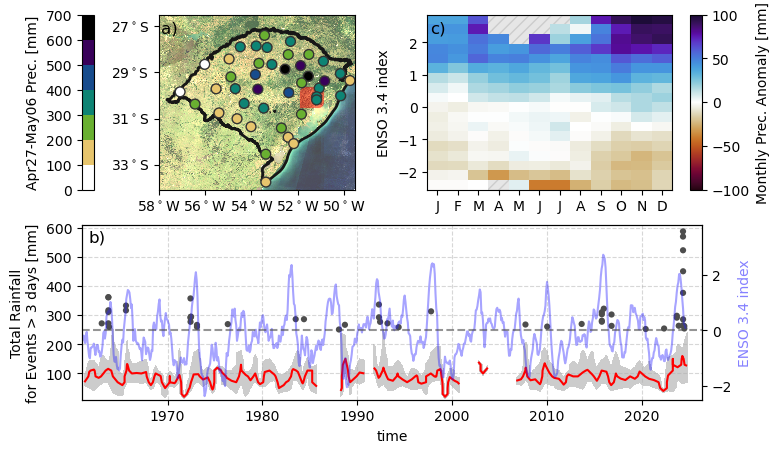

In [486]:
fig = plt.figure(figsize=(8, 5))

# Set up the GridSpec with adjusted width ratios to make C1, C2 narrower and add a spacer
gs = gridspec.GridSpec(2, 6, height_ratios=[1, 1], width_ratios=[0.5, 0.2, 10, 0.5, 10, 0.5], figure=fig)

ax = {}
# Create axes A1, A2, A3 and colorbars C1, C2 using the gridspec layout
ax["C1"] = fig.add_subplot(gs[0, 0])
ax["A1"] = fig.add_subplot(gs[0, 2])
# Spacer between C1 and A2 (empty grid slot)
ax["A2"] = fig.add_subplot(gs[0, 4])
ax["C2"] = fig.add_subplot(gs[0, 5])
ax["A3"] = fig.add_subplot(gs[1, :])  # A3 takes up the full row at the bottom
# ax["C3"] = fig.add_subplot(gs[1, -1])

landsat.plot.imshow(ax=ax["A1"], alpha=0.7)
state.plot(ax=ax["A1"], edgecolor="#171717ff", facecolor="none", linewidth=2)
ax["A1"].set(xlabel="", ylabel="", yticks=np.arange(-33, -26, 2), xticks=np.arange(-58, -48, 2), title="")

ax["A1"].plot(lonlim[[0,1,1,0,0]],latlim[[0,0,1,1,0]], color="red", alpha=0.5, zorder=9, lw=8)

cmap_name = "rainforest_r"
cmap = cmr.get_sub_cmap(f"cmr.{cmap_name}", 0, 1)
bounds = np.arange(0, 701, 100)
norm = mcolors.BoundaryNorm(bounds, ncolors=cmap.N, clip=True)
c = ax["A1"].scatter(rsum.longitude, rsum.latitude, c=rsum.values, s=50, edgecolor="0.2", cmap=cmap, norm=norm, zorder=10)
fig.colorbar(c, cax=ax["C1"], orientation='vertical', pad=-0.2)
# Move y-ticks and label to the left for C1
ax["C1"].yaxis.set_ticks_position('left')
ax["C1"].yaxis.set_label_position('left')
ax["C1"].set_ylabel('Apr27-May06 Prec. [mm]')  # Set the label

ax["A1"].axis("scaled")
format_lat_lon_ticks(ax["A1"], decimals=0)

ax["A2"].axvspan(0,12.5, facecolor="0.9", hatch="///", edgecolor="0.8")
c = rain_enso.plot(ax=ax["A2"], vmin=-100, vmax=100, cmap="cmr.fusion", add_colorbar=False)
fig.colorbar(c, cax=ax["C2"], label="Monthly Prec. Anomaly [mm]")
ax["A2"].set(ylabel="ENSO 3.4 index", xticks=np.arange(1,12+1), xticklabels="J F M A M J J A S O N D".split(), xlabel="");

where = events.total_rain>250

# c = H.resample(time="3m").sum().plot(ax=ax["A3"], cmap=cm.davos_r, robust=True, add_colorbar=False)
# fig.colorbar(c, cax=ax["C3"], label="number of elements")

Hi = H.resample(time="6m").sum()

Hc.plot.contour(ax=ax["A3"], levels=[0.5], colors="r")
Hc.plot.contourf(ax=ax["A3"], levels=[0.2, 0.8], colors="k", alpha=0.2, extend="neither", add_colorbar=False)

a3b = ax["A3"].twinx()
enso_stacked.plot(ax=a3b, color="#251dff66")
a3b.set_ylabel("ENSO 3.4 index", color="#251dff8f")
a3b.set(ylim=[-2.5, 3.8])
a3b.axhline(0, linestyle="--", color="0.3", alpha=0.6)


ax["A3"].scatter(events.time.where(where), events.total_rain.where(where), c="0.3", s=20, edgecolor="none", zorder=1e3)
# ax["A3"].scatter([datetime(2024,4,26)]*rsum.where(rsum>250).size,rsum.where(rsum>250), c="0.3", s=20, edgecolor="none")
ax["A3"].set(xlim=[datetime(1961,1,1), datetime(2026,5,1)], ylabel="Total Rainfall\nfor Events > 3 days [mm]")



ax["A3"].grid(True, ls="--", alpha=0.5)
# for dt in historic_events:
#     ax["A3"].axvline(dt)
# ax["A3"].axvspan(datetime(1985,4,1), datetime(1987,9,1), edgecolor='0.9', facecolor="1.0", lw=0, hatch="//", zorder=2)
# ax["A3"].axvspan(datetime(2000,11,1), datetime(2006,5,1), edgecolor='0.9', facecolor="1.0", lw=0, hatch="//", zorder=2)
# fig.subplots_adjust(wspace=0.5)


for letter, a in zip("a) b) c)".split(), [ax["A1"], ax["A3"], ax["A2"]]):
    a.text(0.01, 0.9, letter, fontsize=12, transform=a.transAxes)

fig.savefig("../img/enso_rain.png", dpi=200, bbox_inches="tight")

In [481]:
da = events.where(events.total_rain>250).stack(obs=["name", "event"]).dropna("obs")

In [507]:
emax, emin = enso_stacked.groupby("time.year").max(), enso_stacked.groupby("time.year").min()
ensoy = emax.where(emax>np.abs(emin), emin)
# ensoy = enso_stacked.groupby("time.year").mean()
years = ensoy.year
ensoy = ensoy.rename(year="time")
ensoy["time"] = [datetime(year,6,15) for year in years]

/tmp/ipykernel_280044/2787463337.py:6: DeprecationWarning: an integer is required (got type DataArray).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  ensoy["time"] = [datetime(year,6,15) for year in years]


In [531]:
(ensoy.interp(time=da.time)>0.5).sum().values/da.time.size, (ensoy.interp(time=da.time)<-0.5).sum().values/da.time.size

(0.6274509803921569, 0.17647058823529413)

In [546]:
((da.time.dt.month>3)&(da.time.dt.month<7)).sum().values/da.time.size

0.45098039215686275

In [552]:
((da.time.dt.month>7)&(da.time.dt.month<11)).sum().values/da.time.size

0.37254901960784315

(array([ 0.,  3.,  2.,  1.,  3.,  5.,  5.,  1.,  3.,  4., 12.,  2.,  1.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5, 11.5, 12.5]),
 <BarContainer object of 13 artists>)

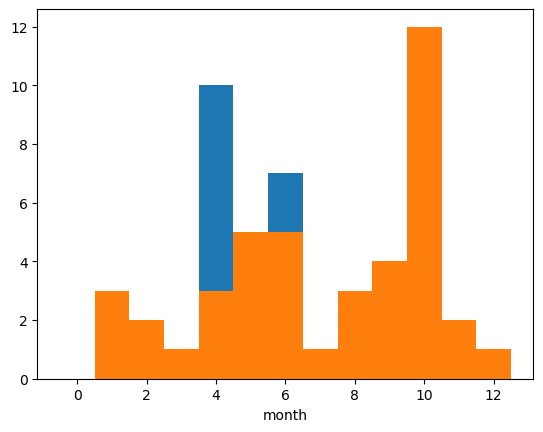

In [550]:
bins = np.arange(-0.5, 13, 1)
da.time.dt.month.plot.hist(bins=bins)
da.time.dt.month.where(da.time.dt.year<2024, drop=True).plot.hist(bins=bins)

(array([ 0.,  0.,  0.,  0.,  2.,  0.,  1.,  0.,  1.,  2.,  2.,  1.,  0.,
         1.,  1.,  1.,  6.,  0.,  0.,  0.,  1.,  5.,  0.,  0., 18.,  2.,
         0.,  1.,  5.,  0.]),
 array([-3.00000000e+00, -2.80000000e+00, -2.60000000e+00, -2.40000000e+00,
        -2.20000000e+00, -2.00000000e+00, -1.80000000e+00, -1.60000000e+00,
        -1.40000000e+00, -1.20000000e+00, -1.00000000e+00, -8.00000000e-01,
        -6.00000000e-01, -4.00000000e-01, -2.00000000e-01,  2.66453526e-15,
         2.00000000e-01,  4.00000000e-01,  6.00000000e-01,  8.00000000e-01,
         1.00000000e+00,  1.20000000e+00,  1.40000000e+00,  1.60000000e+00,
         1.80000000e+00,  2.00000000e+00,  2.20000000e+00,  2.40000000e+00,
         2.60000000e+00,  2.80000000e+00,  3.00000000e+00]),
 <BarContainer object of 30 artists>)

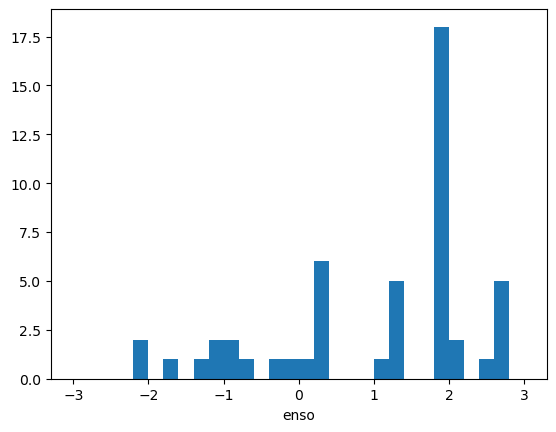

In [524]:
ensoy.interp(time=da.time).plot.hist(bins=np.arange(-3, 3.1, 0.2))

In [488]:
enso_stacked.interp(time=da.time)

<xarray.DataArray 'enso' (obs: 51)> Size: 408B
array([ 2.255     ,  0.66533333,  1.58709677,  1.29870968,  0.80258065,
        0.20096774,  0.66533333,  0.76166667, -0.38193548, -0.676     ,
        0.80258065, -1.00935484,  1.38225806,  0.19935484,  0.66533333,
        0.44548387,  1.29290323,  0.92258065,  0.39129032,  0.39806452,
        1.05066667,  1.38225806,  1.87483871,  0.79129032, -0.715     ,
        2.255     , -0.67066667,  0.76166667,  0.67354839,  0.66533333,
        2.255     ,  0.76166667,  0.66533333,  2.255     ,  0.39129032,
        0.40483871,  0.40571429,  2.21433333,  2.674     ,  1.69741935,
        0.79129032, -0.78967742, -0.86666667,  0.90258065, -1.10419355,
        0.28      ,  1.58709677, -0.102     ,  0.93903226,  0.38833333,
       -1.11      ])
Coordinates:
    time       (obs) datetime64[ns] 408B 2015-10-07 1963-10-09 ... 2022-04-30
    longitude  (obs) float64 408B -55.52 -54.07 -54.07 ... -50.79 -50.79 -50.79
    latitude   (obs) float64 408B -29.69 -31.33 -31.33 ... -28.53 -28.53 -28.53
  * obs        (obs) object 408B MultiIndex
  * name       (obs) <U21 4kB 'ALEGRETE' 'BAGE' 'BAGE' ... 'VACARIA' 'VACARIA'
  * event      (obs) float64 408B 1.282e+03 115.0 499.0 ... 617.0 1.496e+03

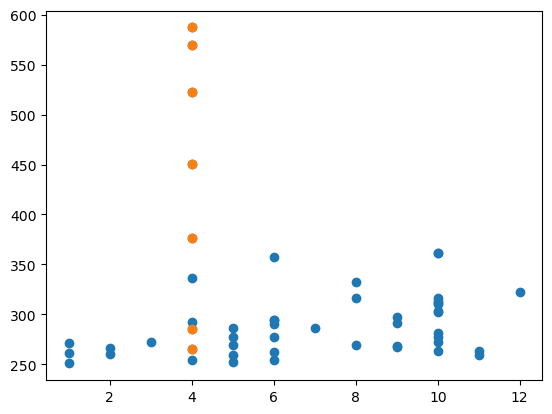

In [484]:
plt.scatter(da.time.dt.month, da.total_rain)

where = (da.time.dt.year==2024)&(da.time.dt.month<6)
plt.scatter(da.time.dt.month.where(where), da.total_rain.where(where))

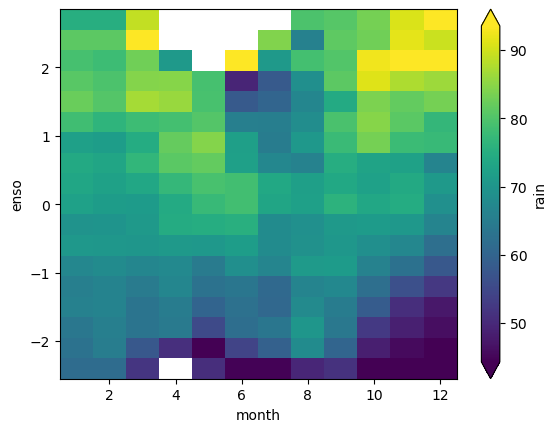

In [380]:
rain_enso_std.plot(robust=True)

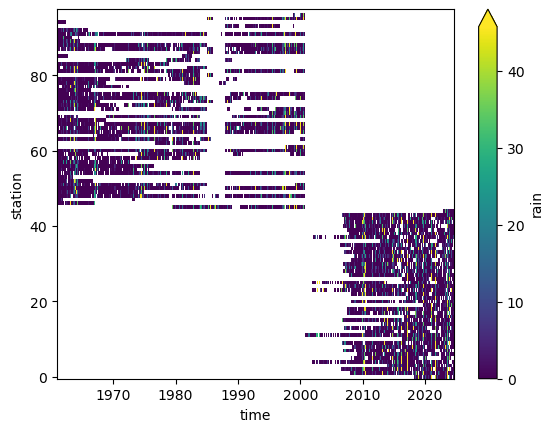

In [551]:
daily.plot(robust= True)

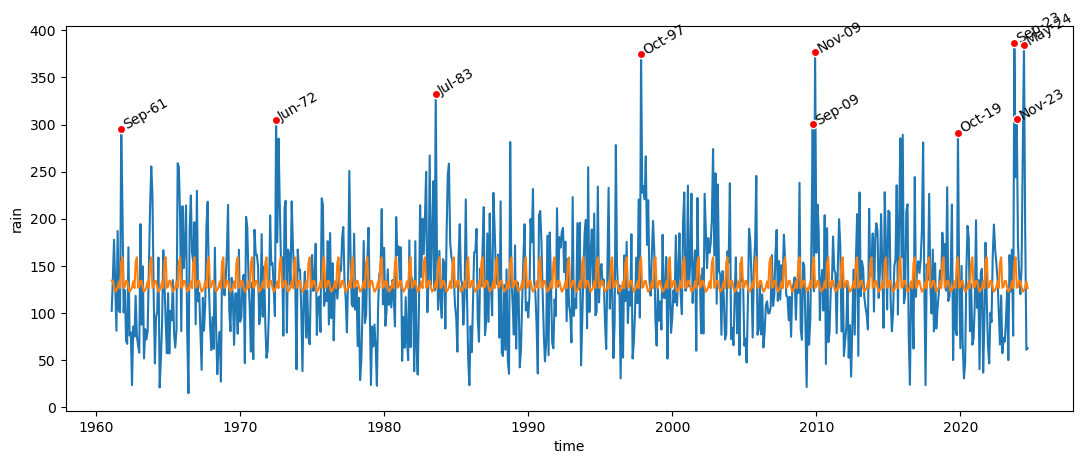